# Pre-processing of prior circadian information
This notebook demonstrates how we established prior information regarding each gene's circadian rhythmicity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## MetaCycle output
We take the output of the R package MetaCycle by _Wu et al._ (10.1093/bioinformatics/btw405). Run on a time-course experiment that was sampled under continous-light (LL).

We chose the RNA-seq experiment by _Romanowski et al._ (10.1111/tpj.14776), as genes withinin this time-course appeared to display the most robust rhythms compared with other studies.

In [3]:
meta_results = pd.read_csv('../data/sfs_input/meta2d_romanowski.csv', index_col=0)
meta_results.head()

,ARS_pvalue,ARS_BH.Q,ARS_period,ARS_adjphase,ARS_amplitude,JTK_pvalue,JTK_BH.Q,JTK_period,JTK_adjphase,JTK_amplitude,meta2d_pvalue,meta2d_BH.Q,meta2d_period,meta2d_phase,meta2d_Base,meta2d_AMP,meta2d_rAMP
CycID,,,,,,,,,,,,,,,,,
AT1G01010,0.006894,0.014558,25.106918,12.847103,0.991468,0.225973,0.418954,24,14.0,1.070217,0.011629,0.022948,24.553459,13.443376,3.338679,1.113735,0.333585
AT1G01020,0.003825,0.009604,20.263959,19.513105,3.406348,0.133629,0.280266,20,0.0,3.336268,0.004385,0.010050,20.131980,19.758998,14.953933,3.397618,0.227206
AT1G01030,0.002032,0.006347,28.514286,21.500242,0.819855,0.040928,0.116564,24,20.0,0.752449,0.000865,0.002663,26.257143,20.839636,4.346134,0.921405,0.212006
AT1G01040,0.050728,0.069996,24.193939,22.116359,1.742976,1.000000,1.000000,28,22.0,3.487879,0.201962,0.267012,26.096970,22.180367,10.119349,1.799373,0.177815
AT1G01046,0.042900,0.060942,15.533074,4.495400,0.929983,0.225973,0.418954,24,16.0,0.929858,0.054639,0.086919,19.766537,9.449145,2.389406,0.752981,0.315133


For our study, we used the meta2d approximation which aggregates the results of both ARS and JTK.

The main circadian metrics we are interested in are the Q-value (representing the robustness of each gene's rhythm) and the phase (representing the shift of each gene's rhythm).

## Phase distribution
Genes do not have even phase distributions. Most tend to peak between dusk and dawn - fewer peak during day time.

Text(0, 0.5, 'Frequency')

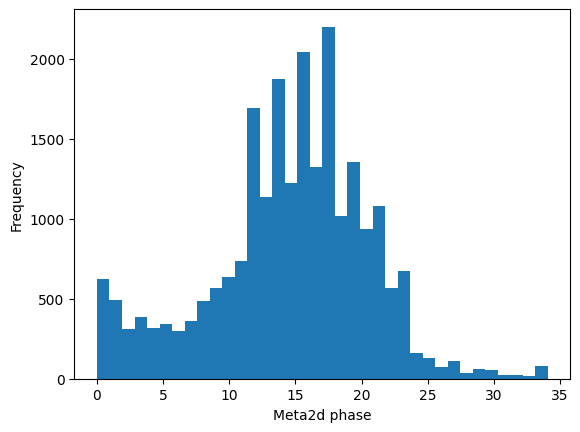

In [9]:
# significant genes Q < 0.05
sig_genes = meta_results[meta_results['meta2d_BH.Q'] < 0.05]
plt.hist(meta_results['meta2d_phase'], bins=36)
plt.xlabel('Meta2d phase')
plt.ylabel('Frequency')

We hypothesized that a model which uses a set of genes with a more balanced set of phases would make more reliable features for circadian time (CT) estimation. This was partially the inspiration for the sequential feature selection method, which requires a phase group/bin for each gene.

## Phase bins
We chose to group each gene into 6 phase bins ranging 0-24 hours iin steps of 4 ([0-4], [4-8], [8-12], [12-16], [16-20], [20-24]).

The choice of 4 hour intervals for each bin was largely heuristic - this approach allows for the capture of genes with diverse waveforms, while reducing the intervals to 2 or 1 hours would increase the duration of the SFS algorithm.

In [15]:
intervals = [4, 8, 12, 16, 20, 24]
phase_bins = []

# label each gene based on phase bin
for i in intervals:
    i_lower = i-4
    # find genes with phases above or equal to the interval-4 but below the interval itself
    i_where = np.intersect1d(np.where(sig_genes['meta2d_phase'] < i)[0], np.where(sig_genes['meta2d_phase'] >= i_lower)[0])
    
    i_genes = sig_genes.iloc[i_where]
    i_genes['phase_bin'] = [i for j in range(0, i_genes.shape[0])]
    i_genes = i_genes[['phase_bin', 'meta2d_BH.Q']]
    i_genes.columns = ['phase_bin', 'qval']

    phase_bins.append(i_genes)

phase_bins = pd.concat(phase_bins)
phase_bins.head()

C:\Users\cjrri\AppData\Local\Temp\ipykernel_24908\1007735945.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_genes['phase_bin'] = [i for j in range(0, i_genes.shape[0])]
C:\Users\cjrri\AppData\Local\Temp\ipykernel_24908\1007735945.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_genes['phase_bin'] = [i for j in range(0, i_genes.shape[0])]
C:\Users\cjrri\AppData\Local\Temp\ipykernel_24908\1007735945.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,phase_bin,qval
CycID,,
AT1G01100,4,0.044503
AT1G01190,4,0.000002
AT1G01610,4,0.009923
AT1G02630,4,0.000691
AT1G02780,4,0.004316


Some form of pripr information is essential for the SFS to select feature sets.

If users would prefer to use some other kind of grouping or rhythmicity metric for each gene, they can fill in the respective columns with these values.